- [[논문 구현] PyToch로 AlexNet(2012) 구현하기](https://deep-learning-study.tistory.com/518?category=983681)
    - error..

In [121]:
# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 데이터셋 불러오고 transformation 적용하기
데이터셋은 torchvision에서 제공하는 STL-10 dataset을 사용합니다.
STL-10 dataset은 train과 test dataset만 제공합니다.
따라서, test dataset을 분할해서 val dataset을 따로 만들어 주겠습니다.

transformation은 resize, horizontal flip, normalize를 적용합니다.

dataset을 불러오고 dataloader로 감싸줍니다.

In [2]:
# loading training dataset
from torchvision import datasets
import torchvision.transforms as transforms
import os

# specify a data path
path2data = './data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load STL10 train dataset, and check
data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download=True, transform=data_transformer)
print(train_ds.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [3]:
# load STL10 test dataset
test0_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [4]:
# calculate the mean and standard deviation of train_ds
import numpy as np

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [5]:
# define the image transformation for trains_ds
# in paper, using normalize, horizontal reflection
train_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(227),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

# define the image transforamtion for test0_ds
test_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
                transforms.Resize(227)
])

In [6]:
# apply transformation to train_ds and test0_ds
train_ds.transform = train_transformer
test0_ds.transform = test_transformer

In [7]:
img, _ = train_ds[1]
print(img.shape)

torch.Size([3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2732
images indices:  2732


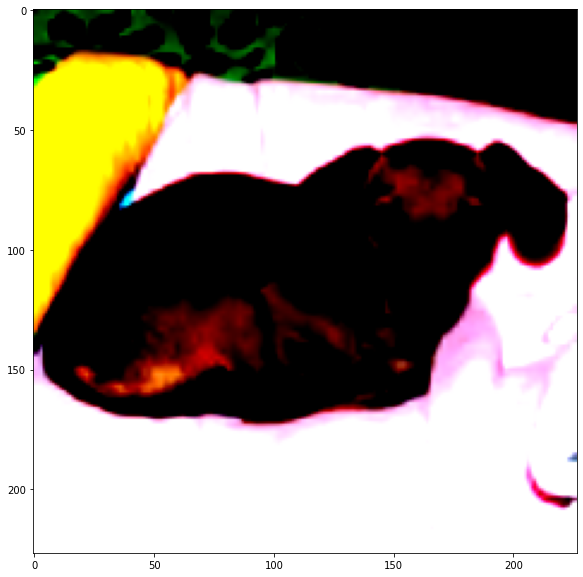

In [8]:
import torch
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# display the transformed sample images from train_ds

# define helper function to show images
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image 
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
print(rnd_inds)
img, label = train_ds[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

In [9]:
# count the number of images per category in train_ds
import collections
y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [10]:
# check test0 dataset
print(test0_ds.data.shape)

(8000, 3, 96, 96)


In [11]:
# split the indices of test0_ds into two groups
# there aren't validation dataset in STL10 dataset, so make validation dataset
# by spliting test0 dataset
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit splits indices of test0 in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test0_ds)))
y_test0 = [y for _,y in test0_ds]

for test_index, val_index in sss.split(indices, y_test0):
    print('test :', len(test_index) , 'val :', len(val_index))

test : 6400 val : 1600


In [12]:
# create two datasets from test0_ds
from torch.utils.data import Subset

# if test0_ds is updated, val_ds and test_ds are updated
# because val_ds and test_ds are a subset of test0_ds
val_ds = Subset(test0_ds, val_index)
test_ds = Subset(test0_ds, test_index)

In [13]:
# count the number of images per calss in val_ds and test_ds
import collections
import numpy as np

y_test = [y for _, y in test_ds]
y_val = [y for _, y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


In [14]:
# create dataloaders from train_ds and val_ds
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# check dataloader
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 227, 227])
torch.Size([32])
torch.Size([32, 3, 227, 227])
torch.Size([32])


# 모델 구축하기

In [15]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 방법 1

In [69]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet,self).__init__()
        # input size : (b x 3 x 227 x 227)
        # 논문에는 image 크기가 224 pixel이라고 나와 있지만, 오타입니다.
        # 227x227을 사용합니다.

        # Conv layer
        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), # (b x 96 x 55 x 55)
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 96 x 27 x 27)

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 256 x 13 x 13)

            nn.Conv2d(256, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(),

            nn.Conv2d(384, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(),

            nn.Conv2d(384, 256, 3, 1, 1), # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # (b x 256 x 6 x 6)
        )

        # fc layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        # weight initialization
        self.init_weight()

    # define weight initialization function
    def init_weight(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # in paper, initialize bias to 1 for conv2, 4, 5 layer
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
    
    def forward(self,x):
        x = self.net(x)
        x = x.view(-1, 256 * 6* 6)
        x = self.classifier(x)
        return x

In [70]:
# check the model
model = AlexNet().to(device)
print(model)

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [71]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [68]:
# check weight initialization
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[-1.5814e-03,  1.0071e-02, -1.3648e-02,  ...,  9.2739e-04,
           -2.4569e-03,  6.6170e-03],
          [-2.3137e-03, -1.6421e-02, -3.7000e-03,  ...,  8.7825e-03,
           -2.2874e-02,  1.6739e-02],
          [ 8.0447e-03,  4.5515e-03,  8.0524e-03,  ...,  1.0742e-03,
           -3.9053e-03,  6.0606e-04],
          ...,
          [-5.1240e-03, -9.8862e-03, -7.7199e-03,  ...,  1.9720e-02,
            4.9390e-03, -6.9947e-03],
          [-1.1516e-02, -1.7657e-02, -4.4088e-03,  ...,  6.0006e-04,
           -3.2601e-03, -1.0434e-02],
          [ 4.8061e-03, -7.7554e-03,  6.5513e-03,  ...,  1.0860e-02,
           -1.7204e-03, -1.4740e-03]],

         [[ 2.4718e-03, -2.7700e-03, -2.5259e-02,  ...,  3.4751e-04,
            1.0823e-02,  5.5681e-04],
          [-1.0001e-02,  6.0625e-03,  2.4227e-04,  ...,  9.5354e-03,
            4.0702e-03,  3.0170e-03],
          [ 1.2053e-02, -6.5134e-03, -2.3986e-03,  ...,  6.0410e-03,
           -7.0010e-04, -3.1376e-03]

# 모델 학습

In [20]:
# define the loss function
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [33]:
# define the optimizer
from torch import optim
# opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
# read the current value of the learning rate using the following function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [23]:
# define lr_scheduler : 1/10 per 10 epochs
from torch.optim.lr_scheduler import StepLR
lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

In [24]:
# define a function to count the number of correct predictions per mini-batch
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [25]:
# define a function to compute the loss value per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)

    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [34]:
# develop a function to compute the loss value and the performance metric for the epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0
    running_metric = 0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batcch to device
        xb = xb.to(device)
        yb = yb.to(device)
        # get model output
        output = model(xb)

        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss += loss_b
        # update running metric
        if metric_b is not None:
            running_metric += metric_b
        
        # break the loop in case of sanity check
        if sanity_check is True:
            break

    # average loss value and metric value
    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

## 방법 1
- `./original/(2012) AlexNet.ipynb`에 있는 방법으로 하면 error 발생

In [35]:
import time
import copy

# develop train_val function
def train_val(model, params):
    # extract model parameters
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    # keep a history of the loss and the metric value
    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # save the best perfirming model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initializer the best loss to an infinite value
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        # train model on trainin dataset
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        # collect loss and metric for the training dataset
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        
        # store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # update the learning rate
        lr_scheduler.step()
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        # print the loss and accuracy values and return the trained model
        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s' %(train_loss, val_loss, 100*val_metric, time.time()-start_time))
        print('-'*10)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [28]:
# define the training parameters
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [29]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/2, current lr=0.01


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 4096]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

## 방법 2
- [CNN, data augmentation X (pytorch, test acc: 74.2)](https://dacon.io/competitions/official/235874/codeshare/4610?page=1&dtype=recent)에서 제시한 코드를 참고해서 구현해보기

In [37]:
# 노트북일 때만 사용
from tqdm.notebook import tqdm
import time
start_time = time.time()

min_loss = int(1e9)
history = []
for epoch in range(100):  # loop over the dataset multiple times
    epoch_loss = 0.0
    tk0 = tqdm(train_dl, total=len(train_dl),leave=False)
    for step, (inputs, labels) in enumerate(tk0, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs= AlexNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.item())
    
    # validation
    class_correct = list(0. for i in range(1000))
    class_total = list(0. for i in range(1000))
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = alexnet(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size()[0]):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # print statistics
    tqdm.write('[Epoch : %d] train_loss: %.5f val_acc: %.2f' %
        (epoch + 1, epoch_loss / 157, sum(class_correct) / sum(class_total) * 100))
    if min_loss < epoch_loss:
        count+=1
        if count > 10 :
            for g in optimizer.param_groups:
                g['lr']/=10
    else:
        min_loss = epoch_loss
        count = 0

print(time.time()-start_time)
print('Finished Training')

  0%|          | 0/157 [00:00<?, ?it/s]

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 1

## 방법 3
- `(2017) DenseNet.ipynb`의 학습 코드 참고

In [38]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [39]:
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [40]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr= 0.01


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 4096]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

## 방법 4
- [[kaggle] Stanford Dogs AlexNet Paper Implementation Pytorch](https://www.kaggle.com/code/virajbagal/stanford-dogs-alexnet-paper-implementation-pytorch)

In [81]:
label

tensor([2, 4, 1, 7, 2, 3, 6, 8, 8, 7, 8, 4, 7, 0, 0, 5, 8, 7, 7, 2, 1, 4, 6, 0,
        9, 4, 7, 0, 3, 5, 3, 6])

In [110]:
for i, batch in enumerate(train_dl):
    print(np.array(batch).shape)
    optimizer.zero_grad()
    img, label = batch
    print(img.shape)
    print('**')
    print(label.shape)
    img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
    
    output = alexnet(img)
    print(output.shape)
    break
#         batch_loss = criterion(output, torch.max(label, 1)[1])
    batch_loss = criterion(output, torch.max(label, 1)[1])

/var/folders/gz/l3tl4gf96231sq9ztwck08x00000gp/T/ipykernel_11103/1914182117.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.array(batch).shape)
/var/folders/gz/l3tl4gf96231sq9ztwck08x00000gp/T/ipykernel_11103/1914182117.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(batch).shape)


(2,)
torch.Size([32, 3, 227, 227])
**
torch.Size([32])
torch.Size([32, 10])


In [130]:
# output = output.argmax(dim=1)
output = alexnet(img)
output.shape
# output
type(output)
label.shape
type(label)
# torch.max(label, 1)[1]

criterion(output, label)

torch.Size([32, 10])

torch.Tensor

torch.Size([32])

torch.Tensor

tensor(75.7165, grad_fn=<NllLossBackward0>)

In [136]:
# torch.autograd.set_detect_anomaly(True)

from torch.optim.lr_scheduler import ReduceLROnPlateau

BATCH_SIZE = 32
criterion= nn.CrossEntropyLoss(reduction='sum')

epochs = 20
losses_df = {'train_loss' : [], 'val_loss' : [], 'val_acc' : []}
num_batches = len(train_ds)//BATCH_SIZE
val_num_batches = len(val_ds)//BATCH_SIZE
best_loss = np.inf
scheduler = ReduceLROnPlateau(optimizer, patience = 4, factor = 0.1, mode = 'min')

alexnet = AlexNet().to(device)

for epoch in range(epochs):
    print('Epoch :', epoch)
    scheduler.step(epoch)
    print('Learning rate :', get_lr(optimizer))
    print('Training for epoch {}'.format(epoch))
    val_outputs = []
    loss = 0
    vloss = 0
    
    alexnet.train()
    for i, batch in enumerate(train_dl):
        optimizer.zero_grad()
        img, label = batch # img : (32, 3, 227, 227) / label : (32,)
        img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
#         img, label = img.to(device), label.to(device)
        output = alexnet(img) # (32, 10)        
        batch_loss = criterion(output, label)
#         batch_loss = criterion(output, label.long())
        batch_loss.backward()
        optimizer.step()
        loss +=batch_loss.item()
        
    train_loss = loss/num_batches
    print('Training loss for epoch {} is {:.4f}'.format(epoch, train_loss))
    losses_df['train_loss'].append(train_loss)
    print('Validation for epoch {}'.format(epoch))
    with torch.no_grad():
        alexnet.eval()
    
        for i, batch in enumerate(val_dl):
            img, label = batch
            img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
            output = alexnet(img)
            batch_loss = criterion(output, label)
#             batch_loss = criterion(output, torch.max(label, 1)[1])
            output = output.detach().cpu().numpy()
            label = label.detach().cpu().numpy()
            val_outputs.extend(np.argmax(output, 1))
            vloss += batch_loss.item()
            
    val_loss = vloss/val_num_batches
    print('Validation loss for epoch {} is {:.4f}'.format(epoch, val_loss))
    losses_df['val_loss'].append(val_loss)
    val_labels = list(np.argmax(np.array(val_y), 1))
    acc = accuracy_score(val_outputs, val_labels)
    print('Accuracy for epoch {} is {:.4f}'.format(epoch, acc))
    losses_df['val_acc'].append(acc)
    
    if val_loss <= best_loss:
        print('Validation loss has reduced from {:.4f} to {:.4f}'.format(best_loss, val_loss))
        print('Saving model')
        best_loss = val_loss
        torch.save(alexnet.state_dict(), 'alexnet_finetuning.pth')

Epoch : 0
Learning rate : 0.01
Training for epoch 0


AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


/Users/lsh/Library/Python/3.9/lib/python/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in ReluBackward0. Traceback of forward call that caused the error:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framew

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 4096]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()